## Bidirectional Neural Representation

A bidirectional network runs in both forward and backward directions. The forward pass propagates signals from the input layer through the hidden layer to the output layer. Backward pass propagates signals from the output layer through the hidden layer to the input layer. Bidirectional training jointly optimizes the directional errors: forward error $E_f$ and backward error $E_b$.



This illustrates the bidirectional representation and learning capability
of a single hidden-layer network.
The network learns the bidirectional representation over binary and bipolar 
permutation functions.

Bipolar permutation function $f: \{-1,1\}^n \rightarrow \{-1, 1\}^n$. Binary permutation function $f : \{0,1\}^n \rightarrow \{0, 1\}^n$

This code applies to two cases of 3-bit and 4-bit permutation functions.

In [1]:
# Import libraries
import tensorflow as tf
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

2024-09-04 00:27:17.355469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 00:27:18.366296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# 3-bit and 4-bit bipolar permutation
def get_data(data_type = "3_bits"):
    """
    Generate the training dataset for a pre-defined 
    3-bit or 4-bit permutation function
    """
    
    if data_type == "3_bits":
        x = np.array([
            [1,1,1], [1,1,-1], [1,-1,1], [1,-1,-1],
            [-1,1,1], [-1,1,-1], [-1,-1,1], [-1,-1,-1]])
        y = x[[6,4,2,0,7,5,3,1]]      
    elif data_type == "4_bits":
        x = np.array([
            [-1,-1,-1,-1],[-1,-1,-1,1],[-1,-1,1,-1],[-1,-1,1,1],
            [-1,1,-1,-1],[-1,1,-1,1],[-1,1,1,-1],[-1,1,1,1],
            [1,-1,-1,-1],[1,-1,-1,1],[1,-1,1,-1],[1,-1,1,1],
            [1,1,-1,-1],[1,1,-1,1],[1,1,1,-1],[1,1,1,1]])
        y = x[[12, 14, 15, 13, 9, 5, 8, 4, 11, 7, 10, 6, 2, 0, 1, 3]]
    else:
        raise ValueError("Wrong input!!! Data type should be 3_bits or 4_bits")
    return x, y

#### Define the model and training parameters

In [3]:
data_type = "4_bits"  # "4_bit"
num_hidden_neurons = 5
mode = 'bipolar'  # "bipolar"
num_epochs = 5000
train_mode = "bidirectional" # ["forward", "backward", "bidirectional"] 

In [4]:
X, Y = get_data(data_type)
if mode == 'binary':
  X = 0.5 * (X+1)
  Y = 0.5 * (Y+1)

#### One hidden layer network: Input layer <--> Hidden Layer <--> Output Layer

In [5]:
## Define the Placeholders !!!
xf = tf.compat.v1.placeholder(tf.float32, [None, X.shape[1]], name = 'input_forward')
yf = tf.compat.v1.placeholder(tf.float32, [None, Y.shape[1]], name = 'target_forward')

xb = tf.compat.v1.placeholder(tf.float32, [None, X.shape[1]], name = 'input_backward')
yb = tf.compat.v1.placeholder(tf.float32, [None, Y.shape[1]], name = 'target_backward')

In [6]:
## Initialize weight
wgts = {}
wgts['U'] = tf.Variable(tf.compat.v1.random_normal([X.shape[1], num_hidden_neurons], stddev = 1.0))
wgts['W'] = tf.Variable(tf.compat.v1.random_normal([Y.shape[1], num_hidden_neurons], stddev = 1.0))

In [7]:
# Forward Pass
ah_f = tf.nn.sigmoid(tf.matmul(xf, wgts['U']))
oy_f = tf.matmul(ah_f, tf.transpose(wgts['W']))
ay_f = oy_f

# Backward Pass
ah_b = tf.nn.sigmoid(tf.matmul(yb, wgts['W']))
ox_b = tf.matmul(ah_b, tf.transpose(wgts['U']))
ax_b = ox_b

In [8]:
# Define the loss function and optimizer
with tf.device('/device:CPU:0'):
  if mode == "binary":
    loss_f = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = yf, logits =  ay_f))
    loss_b = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = xb, logits =  ax_b))
  
  elif mode == "bipolar":
    yf_ = 0.5 * (yf + 1.0)
    xb_ = 0.5 * (xb + 1.0)
    loss_f = tf.reduce_mean(
        tf.maximum(2*ay_f, 0)-(2*ay_f*yf_) + tf.math.log(1 + tf.exp(-tf.abs(2*ay_f)))
        )
    loss_b = tf.reduce_mean(
        tf.maximum(2*ax_b, 0)-(2*ax_b*xb_) + tf.math.log(1 + tf.exp(-tf.abs(2*ax_b)))
        )

  if train_mode == "bidirectional":
      loss = loss_f + loss_b
  elif train_mode == "forward":
      loss = loss_f
  elif train_mode == "backward":
      loss = loss_b
    
  optimizer = tf.compat.v1.train.GradientDescentOptimizer(
        learning_rate = 0.5).minimize(loss)

In [9]:
val_f = np.array([])
val_b = np.array([])

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

2024-09-04 00:27:21.118890: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-09-04 00:27:21.126732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


#### Training

In [10]:
# Train the bidirectional network
val_f = np.array([])
val_b = np.array([])

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

for idx in range(num_epochs + 1):

  # Evaluate the model
  if idx % 50 == 0:
    ef, eb = sess.run([loss_f, loss_b],
                        feed_dict= {xf: X, yf: Y, xb: X, yb: Y})
    val_f = np.append(val_f, ef)
    val_b = np.append(val_b, eb)

  # Update the weights
  sess.run(optimizer, feed_dict= {xf: X, yf: Y, xb: X, yb: Y})

#### Evaluation

In [11]:
# Evaluate the model
pred_y, pred_x= sess.run([ay_f, ax_b],
                         feed_dict= {xf: X, yf: Y, xb: X, yb: Y})

In [12]:
pred_y = (pred_y >= 0).astype(float)
pred_x = (pred_x >= 0).astype(float)
if mode == "bipolar":
  pred_y = (2*pred_y) - 1
  pred_x = (2*pred_x) - 1

In [13]:
# Forward Pass: Compute the approximation error
X - pred_x

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [14]:
# Backward Pass: Compute the approximation error
Y - pred_y

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

#### Synaptic weights (Post-training)

In [15]:
sess.run(wgts['W']).T

array([[ 8.673189 , -1.4582323,  1.2340934, -5.6414275],
       [ 3.6626225,  3.573533 ,  7.6221933,  3.1802049],
       [-8.508298 , -9.742829 ,  1.4747864,  3.7209563],
       [-3.0890124,  8.22007  , -3.7812386, -5.402199 ],
       [-0.5118655, -0.5260154, -6.050979 ,  4.352885 ]], dtype=float32)

In [16]:
sess.run(wgts['U'])

array([[-5.4484286,  4.2676005,  9.791736 , -2.4999874, -6.130385 ],
       [-3.7224166, -6.8921757,  5.909987 , -2.6612217,  6.492222 ],
       [-2.6297529,  4.909919 , -4.6819186, -3.4712236,  5.7156305],
       [-8.26706  ,  3.084792 , -0.2937859,  7.2725477, -1.4360185]],
      dtype=float32)

In [20]:
def plot_directional_error(error, label, color = "blue"):

    plt.plot(np.arange(0,101), error,
             lw =3, color =color, label= label + ' error ' r'$E_{f}(\Theta)$')
    plt.grid()
    
    plt.legend(fontsize = 14, loc = 'best')
    plt.title(label + " Pass", fontsize = 18)
    plt.xlabel(r'Training epoch', fontsize = 18)
    plt.ylabel("Error", fontsize = 18)
    
    plt.xlim(-0.5, 100)
    plt.xticks([0,20,40,60,80,100], fontsize = 15)
    #plt.savefig(label + "_error.eps",format='eps', bbox_inches="tight")
    plt.show()

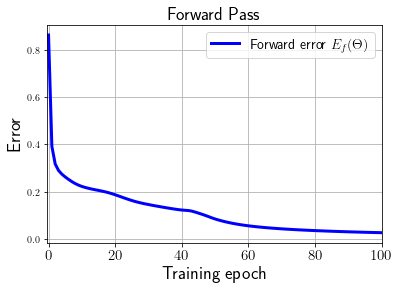

In [21]:
plot_directional_error(error = val_f, label = "Forward", color = "blue")

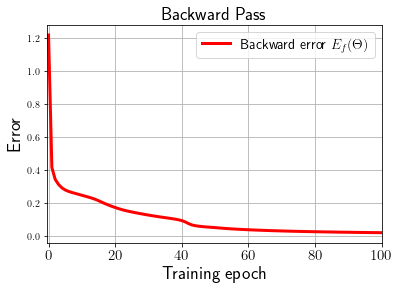

In [22]:
plot_directional_error(error = val_b, label = "Backward", color = "red")